### Simple circuit showcasing entanglement

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

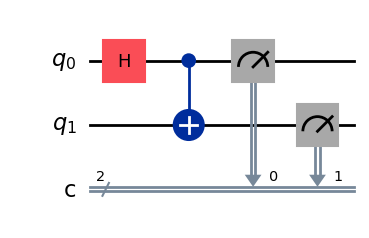

In [4]:
# Create two entangled states
circ_bell = QuantumCircuit(2, 2)
circ_bell.h(0)
circ_bell.cx(0, 1)
circ_bell.measure(range(2), range(2))

circ_bell.draw(output="mpl")

In [5]:
# Run 1000 times and see the results
backend = Aer.get_backend("qasm_simulator")

comp_bell = transpile(circ_bell, backend)
sim_job = backend.run(comp_bell, shots=1000)

sim_counts = sim_job.result().get_counts()

print(sim_counts)

{'11': 514, '00': 486}


In [6]:
# Let's check the amplitudes of the specific states
# For that we remove the measurement and use a statevector simulator

circ_bell2 = QuantumCircuit(2, 2)
circ_bell2.h(0)
circ_bell2.cx(0, 1)

comp_bell2 = transpile(circ_bell2, backend)
backend = Aer.get_backend("statevector_simulator")
job = backend.run(comp_bell2)

state = job.result().get_statevector()

for idx in range(4):
    s = format(idx, "b") # convert to binary
    s = (2 - len(s)) * "0" + s
    print(f"Amplitude of:\t {s} = {state[idx]:.3f}")

print()

for idx in range(4):
    s = format(idx, "b")
    s = (2 - len(s)) * "0" + s
    print(f"Probability of:\t {s} = {abs(state[idx]) ** 2:.3f}")

Amplitude of:	 00 = 0.707+0.000j
Amplitude of:	 01 = 0.000+0.000j
Amplitude of:	 10 = 0.000+0.000j
Amplitude of:	 11 = 0.707+0.000j

Probability of:	 00 = 0.500
Probability of:	 01 = 0.000
Probability of:	 10 = 0.000
Probability of:	 11 = 0.500


### Running on a quantum hardware

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Load saved account
service = QiskitRuntimeService(channel="ibm_quantum_platform")

# List all backends you can access
backends = service.backends()

for backend in backends:
    info = backend.configuration();
    status = backend.status();
    print(
        f"{backend.name:<15} "
        f"Qubits: {info.num_qubits:<3} "
        f"Sim: {info.simulator!s:<5} "
        f"Pending jobs: {status.pending_jobs:<5} "
        f"Operational: {status.operational}"
    )

qiskit_runtime_service.__init__:WARNING:2025-11-03 19:10:30,577: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: eloza. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-03 19:10:30,578: Loading instance: eloza, plan: open


ibm_brisbane    Qubits: 127 Sim: False Pending jobs: 3175  Operational: True
ibm_fez         Qubits: 156 Sim: False Pending jobs: 103   Operational: True
ibm_torino      Qubits: 133 Sim: False Pending jobs: 486   Operational: True
ibm_marrakesh   Qubits: 156 Sim: False Pending jobs: 330   Operational: True


In [ ]:
# get only functional operators, and then extract the least busy
backend = service.least_busy()
print(f"Least busy backend: {backend.name}")
print(f"Has {backend.status().pending_jobs} pending jobs.")

# create a circuit and a classical register
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(2, name="cr")
qc = QuantumCircuit(qr, cr)
qc.h(0)
qc.cx(0, 1)
qc.measure(range(2), range(2))

# create a sampler session
sampler = Sampler(backend)
qc_comp = transpile(qc, backend)
job = sampler.run([qc_comp], shots=1024)

qiskit_runtime_service.backends:WARNING:2025-11-03 18:47:50,125: Using instance: eloza, plan: open


Least busy backend: ibm_fez
Has 139 pending jobs.


{'00': 0.4912109375, '11': 0.494140625, '10': 0.01171875, '01': 0.0029296875}


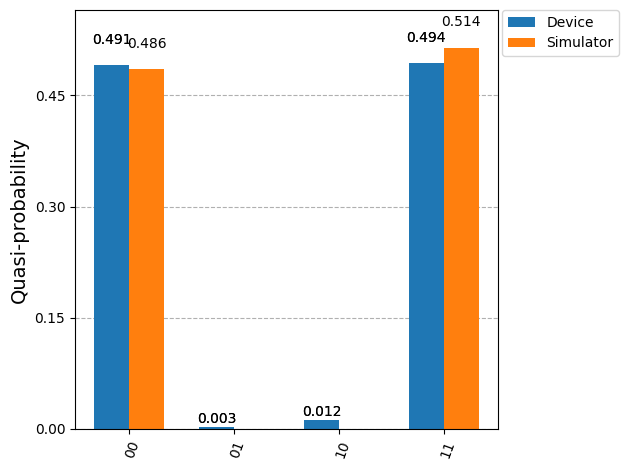

In [ ]:
res = job.result()
counts = res[0].data.cr.get_counts()
for key in counts.keys():
    counts[key] /= 1024
plot_histogram([counts, sim_counts], legend=["Device", "Simulator"])